In [1]:
from rl_agent import Agent # own implementations
from rl_environment import GridWorld # own implementations
from rl_render import Render # own implementations
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML

from tqdm import tqdm
import logging
import warnings
import copy

warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO, format='%(finame)s - %(lineno)d - %(levelname)s : %(message)s',
                     datefmt='%H:%M:%S')
logger = logging.getLogger('my-logger')
logger.propagate = False
# logger.disabled = True

# ploting settings
plt.rcParams["figure.figsize"] = [5, 5]
plt.rcParams["figure.autolayout"] = True

In [2]:
def init_env(config=0):
    '''
    Agent and environment initialization
        args:
            config: int 
                pre-defined grid world configuration
        return: 
            GridWorld object
    '''
    # creating simple grid
    if config==0:
        world = GridWorld(6,6,
                setRewards= {'default': -0.02},
                environmentDynamics='stochastic')
        
        # adding more complexity to the grid (terrains and goals)
        world.addTerminal(('goal',[(0,5),(5,2)]),
                        ('negative_goal',[(2,4)]))
        world.addTerrain(('wall',[(0,2),(1,2),(4,2),(5,0),(5,1)]),
                        ('shortcut', [(1,1),(1,3)]))
    else:
        world = GridWorld(5,5,
                setRewards= {'default': -0.02},
                environmentDynamics='stochastic')
        
        # adding more complexity to the grid (terrains and goals)
        world.addTerminal(('goal',[(4,2)]),
                        ('negative_goal',[(2,4)]))
        world.addTerrain(('wall',[(0,2),(3,2),(4,0),(4,1)]),
                        ('shortcut', [(1,1),(1,3)]))

    return world

# train using general policy iteration
def policy_iteration(agent:Agent, world:GridWorld, render:Render,episodes, method='TD',
                      gamma=0.9, alpha=0.1,epsilon=0.2,s_per_i=200,rtol=0.2,converge_condition='close', 
                      style='color map',render_in_grid=True, **kwargs):
    '''
    train an agent instance using generall Policy Iteration with a specified method argument
        args:
            agent: Agent object
            world: GridWorld object
            render: Render object
            episodes: number of episodes
            method: policy iteration method (TD, MC, DP)
            gamma: discount factor
            alpha: learning rate
            epsilon: exploration rate
            s_per_i: steps per iteration
            rtol: relative tolerance
            converge_condition: convergence condition
            style: render style (image or color map)
            render_in_grid: render in grid
            kwargs: additional arguments
        return:
            measurments: avrage returns / episode / wall clock time
            tracked_Qsa: the Q values of the tracked states-action pairs
    '''
    agent.reset(world)
    heuristic_pi = agent.policyGenerator(world)
    measurments = None
    tracked_Qsa = None

    if method=='MC':
        policy, measurments, tracked_Qsa = agent.MC_policyIteration(world,policy=heuristic_pi, max_iterations=episodes,
                                                    gamma=gamma,epsilon=epsilon,
                                                    converge_condition=converge_condition,steps_per_iter=s_per_i ,rtol=rtol, **kwargs)
        iterations = len(measurments['iteration'])
    elif method=='TD':
        policy, measurments, tracked_Qsa = agent.TD_SARSA_policyIteration(world,policy=heuristic_pi, max_iterations=episodes,
                                                    gamma=gamma,alpha=alpha,epsilon=epsilon, 
                                                    converge_condition=converge_condition,steps_per_iter=s_per_i ,rtol=rtol, **kwargs)
        iterations = len(measurments['iteration'])
    elif method=='DP':
        policy, iterations = agent.DP_policyIteration(world,policy=heuristic_pi, max_iterations=episodes,
                                                    gamma=gamma,epsilon=epsilon,
                                                    converge_condition=converge_condition,steps_per_iter=s_per_i ,rtol=rtol, **kwargs)
    else:
        raise ValueError('please pick a method for the policy iteration algorithem. Options : [ "TD" , "MC" , "DP" ]')

    if render_in_grid: 
        render.renderEnv(style=style, results=True,
                        title=f'policy iteration: {method}\n gamma:{gamma},alpha:{alpha},converged_in={iterations} from max {episodes}')

    return measurments , tracked_Qsa

def policy_iteration_as_generator(agent:Agent, world:GridWorld, render:Render,episodes, 
                      gamma=0.9, alpha=0.1,epsilon=0.2,s_per_i=200,rtol=0.2,converge_condition='close', 
                      style='color map', method='DP',render_in_grid=True, **kwargs):
    '''
    create a generator for the policy iteration method specified by the method argument
        args:
            agent: Agent object
            world: GridWorld object
            render: Render object
            episodes: number of episodes
            method: policy iteration method (TD, MC, DP)
            gamma: discount factor
            alpha: learning rate
            epsilon: exploration rate
            s_per_i: steps per iteration
            rtol: relative tolerance
            converge_condition: convergence condition
            style: render style (image or color map)
            render_in_grid: render in grid
            kwargs: additional arguments
        return:
            generator for the policy iteration method specified by the method argument
    '''
    agent.reset(world)
    heuristic_pi = agent.policyGenerator(world)
    ############ return a generator for TD policy iteration ############
    gen = None
    if method=='TD':
        gen = agent.gen_TD_SARSA_policyIteration(world,policy=heuristic_pi, max_iterations=episodes,
                                                    gamma=gamma,alpha=alpha,epsilon=epsilon, 
                                                    converge_condition=converge_condition,steps_per_iter=s_per_i ,rtol=rtol, **kwargs)
    else:
        raise ValueError('please pick a method for the policy iteration algorithem. Options : [ "TD" ]')
    
    return gen

def plot_measurments(measurments:pd.DataFrame, title:str=None):
    '''
    plot measurments dataframe
        args:
            measurments: measurments dataframe as pandas.Dataframe
            title: plot title (str)
    '''
    episodes_returns = copy.copy(measurments['episode_returns'])
    episode_wall_clock_times = copy.copy(measurments['episode_times'])
    # episode_wall_clock_times *= 1000 # convert to ms

    avr_returns = np.zeros_like(episodes_returns)
    for i in range(len(episodes_returns)):
        avr_returns[i] = np.mean(episodes_returns[:i+1])

    fig, (ax_1,ax_2) = plt.subplots(1,2,sharey=True)
    ax_1.plot(np.arange(1,avr_returns.size + 1) ,avr_returns,label='average return')
    ax_1.set_xlabel('episode')
    # ax_1.legend()

    ax_2.plot(episode_wall_clock_times,avr_returns,label='average return')
    ax_2.set_xlabel('wall clock time (s)')
    # ax_2.legend()

    fig.supylabel('Average return')
    fig.suptitle(title)

    plt.show(block=False)

def plot_tracked_Qsa(tracked_Qsa_means:dict, tracked_Qsa_stds:dict, method='TD', title=None):
    '''
    plot the Q_values of the tracked states-action pairs
        args:
            tracked_Qsa_means: dictionary of the tracked Qsa means (dict)
            tracked_Qsa_stds: dictionary of the tracked Qsa stds (dict)
            method: policy iteration method (TD, MC, DP)
            title: plot title (str)
    '''
    fig = plt.figure()
    ax = fig.add_subplot()
    for pair in tracked_Qsa_means.keys():
        Q_values_sa_means = np.array(tracked_Qsa_means[pair])
        Q_values_sa_stds = np.array(tracked_Qsa_stds[pair])
        ax.plot(Q_values_sa_means,label=f'{method} Q{pair} - mean')
        ax.plot(Q_values_sa_stds, linestyle='--',label=f'{method} Q{pair} - std')
        ax.fill_between(np.arange(Q_values_sa_means.size), Q_values_sa_means - Q_values_sa_stds, Q_values_sa_means + Q_values_sa_stds, alpha=0.2)
    ax.set_xlabel('episode')
    ax.legend()
    fig.suptitle(title)
    plt.show(block=False)

def avrg_measurments_over_iterations(iterations=10, **kwargs):
    '''
    average measurments over multiple iterations of policy iteration
        args:
            iterations: number of iterations (int)
            kwargs: additional arguments for the policy iteration function (policy_iteration)
        return:
            average measurments dataframe (pandas dataframe)
    '''

    samples_measurments = np.array([policy_iteration(**kwargs) for _ in tqdm(range(iterations), desc='multiple iterations of policy iteration')])
    all_measurments = samples_measurments[:,0]
    
    all_episode_returns = [all_measurments[i]['episode_returns'] for i in range(iterations)]
    episode_returns_means = np.mean(all_episode_returns,axis=0)
    all_episode_wall_clock_times = [all_measurments[i]['episode_times'] for i in range(iterations)]
    episode_wall_clock_times_means = np.mean(all_episode_wall_clock_times,axis=0)
    measurments_means = pd.DataFrame({'episode_returns':episode_returns_means,'episode_times':episode_wall_clock_times_means})

    all_tracked_Qsa = samples_measurments[:,1]
    tracked_Qsa_means = {(sa_pair): np.mean(np.array([Q_sa_dict[sa_pair] for Q_sa_dict in all_tracked_Qsa]),axis=0) for sa_pair in all_tracked_Qsa[0].keys()}
    tracked_Qsa_stds = {(sa_pair): np.std(np.array([Q_sa_dict[sa_pair] for Q_sa_dict in all_tracked_Qsa]),axis=0) for sa_pair in all_tracked_Qsa[0].keys()}

    return measurments_means, tracked_Qsa_means, tracked_Qsa_stds

In [3]:
# variables for training
episodes_num = 1000
gamma= 0.9
alpha= 0.1
epsilon= 0.2
ignore_converged_s= 0.2 
max_steps_per_iteration= 400 
relativ_tolerance = 1e-3 # the relative accurecy for testing for policy convergence
absolut_tolerance = 1e-8 # the abolute accurecy for testing for policy convergence

# creating an environment
world = init_env(config=0)

# creating an agent in the gridworld
agent = Agent(environment=world)

# creating render object 
render = Render(env=world, agent=agent)

# initiate rendering resources
render.init_rendering_resources(configuration=0)
render.start()

policy_iteration_kwargs = {'agent':agent,'world':world,'render':render,'episodes':episodes_num,
                 'gamma':gamma,'alpha':alpha,'epsilon':epsilon,'s_per_i':max_steps_per_iteration,
                 'atol':absolut_tolerance, 'converge_condition':'close'}


100%|██████████| 1000/1000 [00:00<00:00, 1175.18it/s]


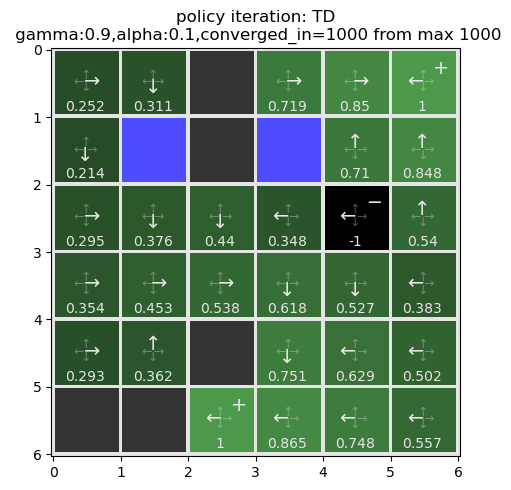

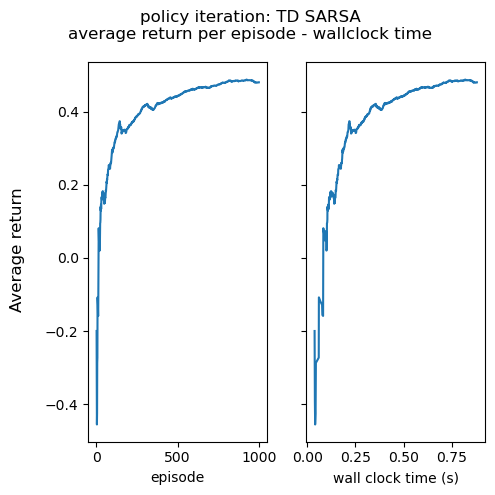

In [4]:
# train the agent using TD policy iteration
episodes_num = 1000
policy_iteration_kwargs['episodes'] = episodes_num

measurments, tracked_Qsa = policy_iteration(**policy_iteration_kwargs, style='color map',show_pbar=True, method='TD')
render.show()

plot_measurments(measurments,title=f'policy iteration: TD SARSA\naverage return per episode - wallclock time')

100%|██████████| 1000/1000 [00:02<00:00, 407.02it/s]


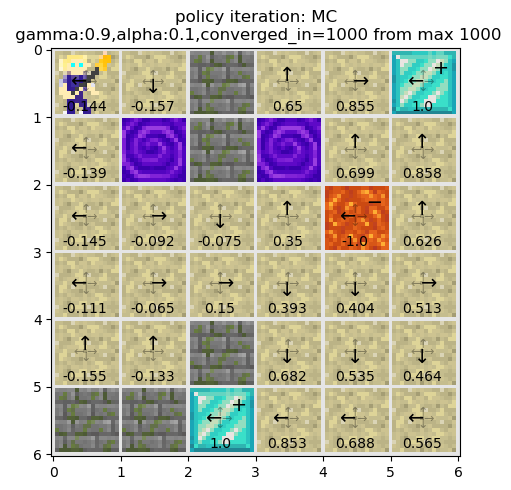

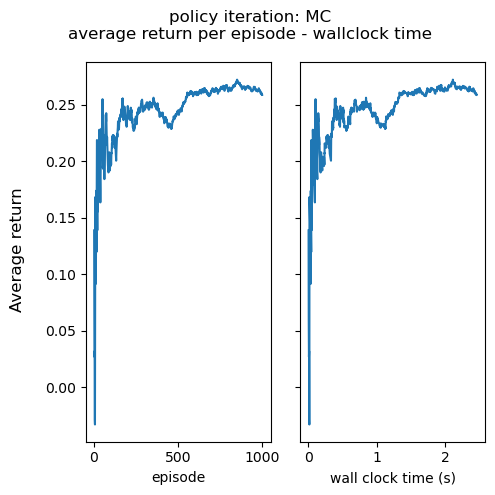

In [5]:
# train the agent using MC policy iteration
measurments, tracked_Qsa = policy_iteration(**policy_iteration_kwargs, style='image',show_pbar=True, method='MC',)
render.show()

plot_measurments(measurments,title=f'policy iteration: MC\naverage return per episode - wallclock time')

recording episodes:   0%|          | 0/121 [00:00<?, ?it/s]rl_agent.py - 754 - INFO : ######## ----------- START generator TD SARSA POLICY ITERATION ------------------##########
recording episodes: 1001it [00:05, 171.88it/s]                       
animation.py - 1052 - INFO : Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
animation.py - 327 - INFO : MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 500x500 -pix_fmt rgba -r 10.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y videos/training_animation.mp4
animation.py - 1052 - INFO : Animation.save using <class 'matplotlib.animation.HTMLWriter'>


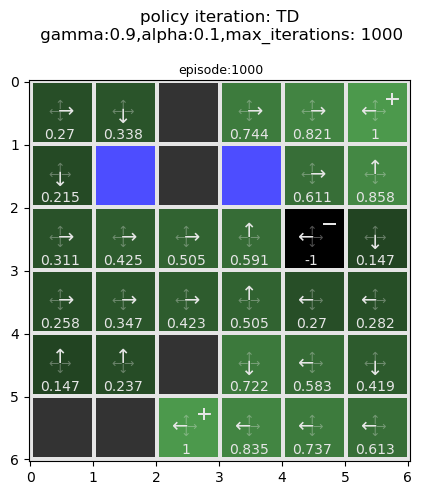

In [8]:
# animate training for TD policy iteration
episodes_num = 1000
policy_iteration_kwargs['episodes'] = episodes_num
policy_iteration_kwargs['render_in_grid'] = False

# animation settings, change as you wish 
# the more frames the longer it takes to create the animation
record_range = (0,1000) # range of episodes to record
partition = 10 # record an episode each x episodes
frame_delay = 100 # delay between frames in ms
# or use pick the episodes to record by setting costum_record to a list of indecies
# this will override the record_range and partition settings
costume_episodes_to_record = np.concatenate((np.arange(0,50,dtype=int),
                                             np.arange(50,200,3,dtype=int),
                                             np.arange(200,episodes_num+1,40,dtype=int)))# episodes to record 


# aditionaly you can save the animation by setting save=True, and change the path and filename if you wish
# default path is 'videos/' and default filename is 'training_animation.mp4'
# if you save the animation it makes sense to not show it in the notebook ( double animation creation time )

# create a policy iteration generator (TD)
TD_generator = policy_iteration_as_generator(**policy_iteration_kwargs,method='TD')

title = f'policy iteration: TD\n gamma:{gamma},alpha:{alpha},max_iterations: {episodes_num}'

# create the animation , returns ( the animation object , and a list of the values of the policy iteration )
anim, _ = render.animate_training(TD_generator,title=title,
                        partition=partition,range=record_range, frame_delay=frame_delay,
                        costum_record=costume_episodes_to_record,
                        save=True,path='videos/', filename='training_animation.mp4')

HTML(anim.to_jshtml())

In [7]:
# variables for training with both TD and MC for x episodes for y iterations for averaging and comparesion
episodes_num = 1000
track_sa_pairs = (((0,0),'L'),((0,1),'L'),((3,2),'R')) # track all these state-action pairs
state_action_pair = track_sa_pairs[0] # pick a state-action pair for plotting

policy_iteration_kwargs['episodes'] = episodes_num
policy_iteration_kwargs['track_sa_pairs'] = track_sa_pairs

iterations = 100

In [8]:
# train the agent using TD policy iteration and track the state-action pair over iterations
TD_measurments_means, TD_tracked_Qsa_means, TD_tracked_Qsa_stds = avrg_measurments_over_iterations(iterations,**policy_iteration_kwargs,method='TD')

multiple iterations of policy iteration: 100%|██████████| 100/100 [01:25<00:00,  1.17it/s]


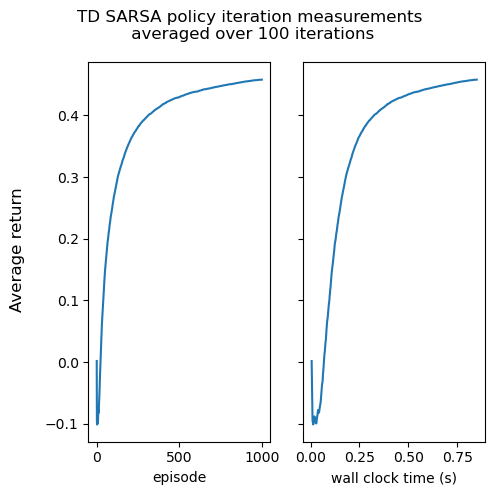

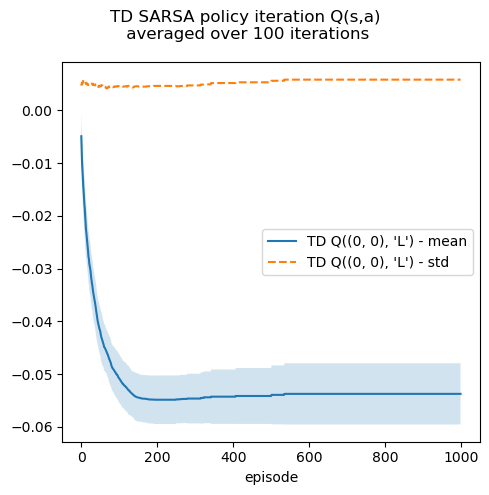

In [9]:
# plot results of TD policy iteration
# plot the average return per episode and wallclock time over iterations 
plot_measurments(TD_measurments_means, title=f'TD SARSA policy iteration measurements\n averaged over {iterations} iterations')

# plot the average Q(s,a) over iterations for the tracked state-action pair
TD_means_dict = {state_action_pair: TD_tracked_Qsa_means[state_action_pair]}
TD_stds_dict = {state_action_pair: TD_tracked_Qsa_stds[state_action_pair]}
plot_tracked_Qsa(TD_means_dict, TD_stds_dict, method='TD', title=f'TD SARSA policy iteration Q(s,a)\n averaged over {iterations} iterations')

In [10]:
# train the agent using MC policy iteration and track the state-action pair over iterations
MC_measurments_means, MC_tracked_Qsa_means, MC_tracked_Qsa_stds = avrg_measurments_over_iterations(iterations,**policy_iteration_kwargs,method='MC')

multiple iterations of policy iteration: 100%|██████████| 100/100 [04:28<00:00,  2.68s/it]


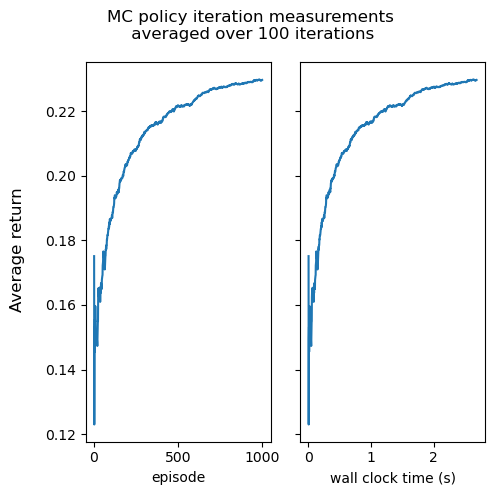

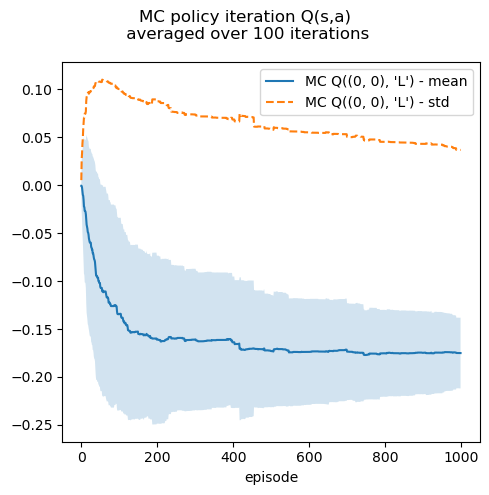

In [11]:
# plot results of MC policy iteration
# plot the average return per episode and wallclock time over iterations
plot_measurments(MC_measurments_means, title=f'MC policy iteration measurements\n averaged over {iterations} iterations')

# plot the average Q(s,a) over iterations for the tracked state-action pair
MC_means_dict = {state_action_pair: MC_tracked_Qsa_means[state_action_pair]}
MC_stds_dict = {state_action_pair: MC_tracked_Qsa_stds[state_action_pair]}
plot_tracked_Qsa(MC_means_dict, MC_stds_dict, method='MC', title=f'MC policy iteration Q(s,a)\n averaged over {iterations} iterations')

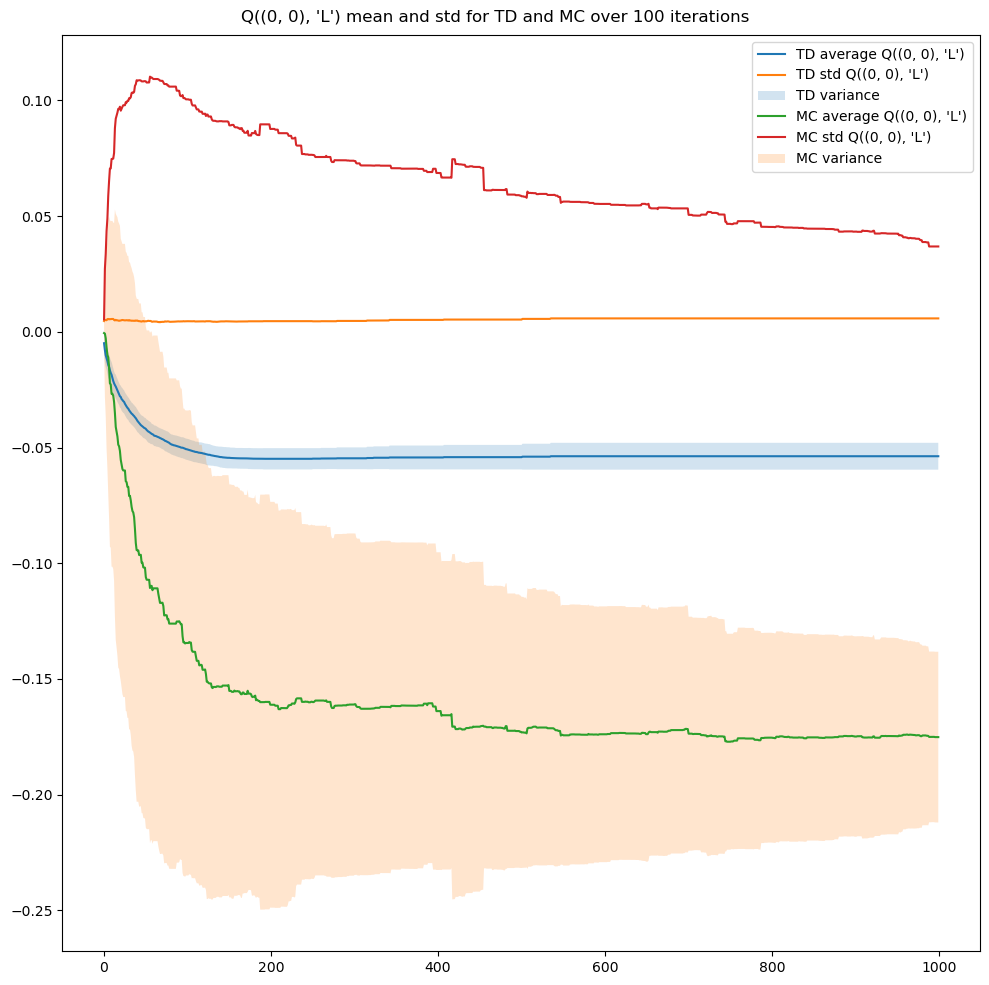

In [12]:
# the plots together for comarisions
TD_means = TD_means_dict[state_action_pair]
TD_stds = TD_stds_dict[state_action_pair]
MC_means = MC_means_dict[state_action_pair]
MC_stds = MC_stds_dict[state_action_pair]

fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle(f'Q{state_action_pair} mean and std for TD and MC over {iterations} iterations')
ax.plot(TD_means, label=f'TD average Q{state_action_pair}')
ax.plot(TD_stds, label=f'TD std Q{state_action_pair}')
ax.fill_between(range(len(TD_means)),TD_means +TD_stds,TD_means-TD_stds,alpha=0.2,label='TD variance')

ax.plot(MC_means, label=f'MC average Q{state_action_pair}')
ax.plot(MC_stds, label=f'MC std Q{state_action_pair}')
ax.fill_between(range(len(MC_means)),MC_means+MC_stds,MC_means-MC_stds,alpha=0.2,label='MC variance')

ax.legend()
plt.show(block=False)

### Iterpretation:
we can clearly see the biase / variance tradeoff between the MC and TD SARSA approaches, MC has a much higher variance throughout all stages of training and low bias, where as TD SARSA has a much lower variance and higher bias.  
this is due to the fact that MC is sampling the entire episode and then updating the Q values, where as TD SARSA is updating the Q values after each step and in dependence of the previous Q values.
another important observation is that the std of MC has in average a decendent gradient, which means that the variance is decreasing with more training, so we can in a sense observe the convergence of the MC approach when tending toward infinite training loops.